In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [2]:
features1 = pd.read_pickle("training_sets/features1")

In [3]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [8]:
Dates = np.append(np.append(Date1, Date2), Date3)

In [9]:
prediction_dates = np.linspace(999, len(Dates) - 120, 10).astype(int)

In [10]:
f = ["Class_binary_5_20", "Class_binary_10_20", "Class_binary_20_20", "Class_binary_40_20", "Class_binary_80_20"]
b = ["return_5", "return_10", "return_20", "return_40", "return_80"]


In [11]:
cols_trials = []
for i in range(10):
    cols_trials.append(np.random.choice(features1.columns[:-11], 18, replace = False))

In [12]:
all_cols = np.array([])
for i in cols_trials:
    all_cols = np.append(all_cols, i)

In [13]:
unique_cols = np.unique(all_cols)

In [14]:
unique_cols = np.append(unique_cols, np.append(f, b))

In [16]:
len(unique_cols)

147

In [17]:
params2 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [18]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col, return_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), return_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40 = X_test.pop(return_col)
    
    return X_train, X_test, Y_train, Y_test, Y_return_40

In [19]:
def return_40_metric(pred, labels):


    return np.mean(labels[np.argsort(pred)[:500]]), (1-np.sort(pred)[499]), np.mean(labels[np.argsort(pred)[:100]]), (1-np.sort(pred)[99]), np.mean(labels[np.argsort(pred)[:20]]), (1-np.sort(pred)[19])

In [20]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):


        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [26]:
results = []
for prediction_date in prediction_dates:
    
    results1 = []
    
    
    for pred_col, return_col in zip(f, b):
        
        
        start_time_df_create = time.perf_counter()
        
        results2 = []
        
        
        training_period = Dates[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

        prediction_period = Dates[prediction_date :prediction_date + 20 + 1]
        
        
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):
        
            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   
                
                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            X_train_master = features1.loc[Date1_intersect, unique_cols]
            

        else:

            if "features1" in locals():
                del features1
                
                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):
            
            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")
                
                print("imported features2")
                
            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, unique_cols])
                
            else:
                
                X_train_master = features2.loc[Date2_intersect, unique_cols]
                
        else:

            if "features2" in locals():
                del features2
                
                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")
                
                print("imported features3")
                
                
            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, unique_cols])
                
            else:
                
                X_train_master = features3.loc[Date3_intersect, unique_cols]

        else:

            if "features3" in locals():
                del features3
                
                print("deleted features3")
                
                
        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
        
        for indx, cols in enumerate(cols_trials):
            
            start_time_train = time.perf_counter()
            
            results3 = []
            
            X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, pred_col, return_col)
            
            train_weights = Y_train.map({0:19, 1:1})
            
            xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)
            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)
            
            data = []
        
            mycallback = my_callback(xgtest, Y_return_40, data)

            start_time = time.perf_counter()
            bst = xgboost.train(params2, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback])


            results3.append(Dates[prediction_date])
            results3.append(pred_col)
            results3.append(cols)
            results3.append(time.perf_counter() - start_time_train)
            results3.append(data)

            results2.append(results3)

            print(time.perf_counter() - start_time_train)
            
        results1.append(results2)
            
 
            
        del X_train_master
        
    results.append(results1)
    
    with open('PredictionWindow/5vs10vs20vs40vs80.pkl', 'wb') as f:
        pickle.dump(results, f)
            


imported features1
deleted features3
df_create_time: 12.964853800000014
4.757065899999986
4.662001099999998
4.778886700000044
4.481978700000013
4.743496800000003
4.6718025000000125
4.482154500000036
4.357830499999977
4.516957900000023
4.46261770000001
df_create_time: 0.5768203999999741
4.626782300000002
4.596389399999964
4.641754100000014
4.3757302999999865
4.7275650999999925
4.654696800000011
4.474610600000005
4.344233699999961
4.5310894999999505
4.51988659999995
df_create_time: 0.5885850999999889
4.608154200000001
4.574288700000011
4.670371299999999
4.374617500000056
4.734559899999965
4.659430500000042
4.468075100000021
4.323324600000035
4.491750199999956
4.450156800000059
df_create_time: 0.5906459000000268
4.594789699999978
4.525232000000074
4.623439500000018
4.384944000000019
4.752175999999963
4.650390300000026
4.461801899999955
4.341170099999999
4.445237099999986
4.458105499999988
df_create_time: 0.5873547999999573
4.536179999999945
4.485913200000027
4.58906479999996
4.38283449999

In [31]:
np.shape(results[0][0][0][4])

(20, 6)

In [32]:
window_5 = []
window_10 = []
window_20 = []
window_40 = []
window_80 = []

for pred_date in range(10):
    
    for pred_window in range(5):
        
        for col_indx in range(10):
            
            if pred_window == 0:
            
                window_5.append(np.array(results[pred_date][pred_window][col_indx][4])[:,4])
                
            elif pred_window == 1:
                window_10.append(np.array(results[pred_date][pred_window][col_indx][4])[:,4])
                
            elif pred_window == 2:
                window_20.append(np.array(results[pred_date][pred_window][col_indx][4])[:,4])
                
            elif pred_window == 3:
                window_40.append(np.array(results[pred_date][pred_window][col_indx][4])[:,4])
            
            else:
                window_80.append(np.array(results[pred_date][pred_window][col_indx][4])[:,4])
                

In [37]:
(1 + (np.mean(window_5, axis = 0) / 100)) ** (80/5)

array([1.12882895, 1.2720924 , 1.19900161, 1.15916279, 1.28184201,
       1.28384194, 1.375503  , 1.43646843, 1.41941973, 1.39174999,
       1.41491961, 1.3296718 , 1.32892027, 1.34224871, 1.27768605,
       1.25952874, 1.23365804, 1.20836943, 1.21953923, 1.21575206])

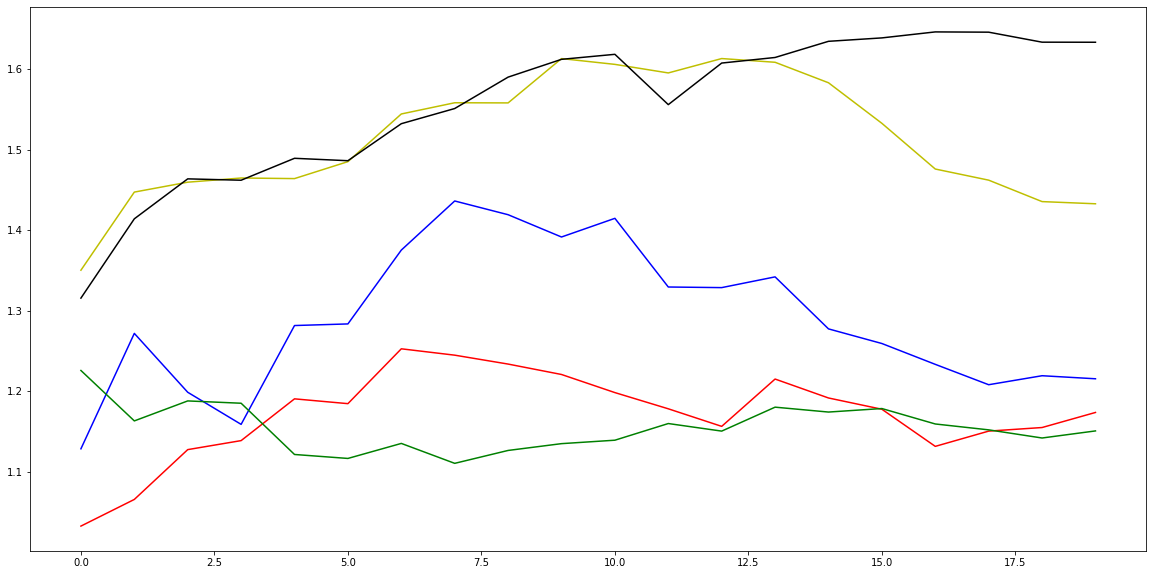

In [40]:
plt.figure(figsize = (20, 10))
#plt.plot(np.mean(window_5, axis = 0), "b")
#plt.plot(np.mean(window_10, axis = 0), "r")
#plt.plot(np.mean(window_20, axis = 0), "g")
#plt.plot(np.mean(window_40, axis = 0), "y")
#plt.plot(np.mean(window_80, axis = 0), "black")
plt.plot((1 + (np.mean(window_5, axis = 0) / 100)) ** (80/5), "b")
plt.plot((1 + (np.mean(window_10, axis = 0) / 100)) ** (80/10), "r")
plt.plot((1 + (np.mean(window_20, axis = 0) / 100)) ** (80/20), "g")
plt.plot((1 + (np.mean(window_40, axis = 0) / 100)) ** (80/40), "y")
plt.plot((1 + (np.mean(window_80, axis = 0) / 100)), "black")

